In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
pd.set_option('display.max_columns', None)

import numpy as np
import glob
import os
import json

import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)


/usr/bin/python


[main] Found existing base CSV: dfs/AAPL_1_base.csv


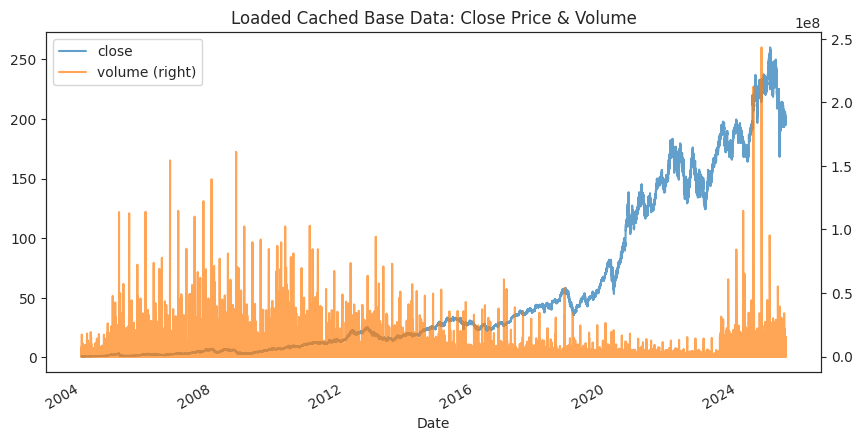

open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         ask         bid  
2004-01-02 09:00:00     28000.0    0.764857    0.763714  
2004-01-02 09:01:00     28000.0    0.764857    0.763714  
2004-01-02 09:02:00     28000.0    0.764857    0.763714  
2004-01-02 09:03:00     28000.0    0.764857    0.763714  
2004-01-02 09:04:00     28000.0    0.764857    0.763714  
...                         ...         ...         ...  
2025-06-18 20:56:00    385695.0  196.962600  196.667400  
2025-06-18 20:57:00    460630.0  196.822500  196.527500  
2025-06-18 20:58:00    525245.0  196.817500  196.522500  
2025-06-18 20:59:00   2075503.0  196.387200  196.092800  
2025-06-18 21:00:00  15600625.0  196.687400  196.392600  

[3893400 rows x 7 columns]

In [2]:
base_csv = params.base_csv

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder              = params.stocks_folder,
        ticker              = params.ticker,
        bidasktoclose_pct   = params.bidasktoclose_pct
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                = df_raw,
        sess_premark      = params.sess_premark,
        sess_start        = params.sess_start,
        sess_end          = params.sess_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [3]:
# def process_single_day(day_str: str, best_optuna_params: dict):
#     """
#     Process and plot a single trading session using a given set of hyperparameters.

#     Returns:
#       Tuple[pd.DataFrame, Dict] | None
#         If a valid backtest runs, returns (df_day, perf_day).
#         If no data or no trades, returns None.
#     """
#     print(f"\n---------------------------------------------------------------------------------------------------------------------------------------------------\n")
#     print(f"\n=== Processing trading day {day_str} ===")
#     day_dt = pd.to_datetime(day_str)
#     # Extract that day’s full-minute bars from the master df
#     day_df = df.loc[df.index.normalize() == day_dt].copy()
#     if day_df.empty:
#         print(" no data; skipping.")
#         return

#     print("\n Running trading pipeline on selected date …")
#     # Call run_trading_pipeline with your per-day slice + EXACTLY the same best_optuna_params
#     result = trades.run_trading_pipeline(
#                                         df                       = day_df,
#                                         col_signal               = 'signal', # name for the signal column to use
#                                         col_action               = 'signal_action' # name for the trade-action column to add
#                                         **best_optuna_params            # unpack tuned parameters here
#     )
#     if result is None:
#         print(" no trades found; skipping.")
#         return

#     # Unpack pipeline output: (df_signals, trades_list, performance_stats)
#     df_day, trades_day, perf_day = result

#     # Plot the equity & trade markers
#     plots.plot_trades(
#                     df                 = df_day,
#                     col_signal1        = 'signal',
#                     col_signal2        = False,
#                     col_action         = 'signal_action',
#                     trades             = trades_day,
#                     buy_threshold      = best_optuna_params['buy_threshold'],
#                     performance_stats  = perf_day,
#                     start_plot         = params.sess_start # or sess_premark 
#     )

#     # Print the per-day summary
#     print(f"\n* Performance for {day_dt.date()} *")
#     for k, v in perf_day.items():
#         print(f"  {k}: {v}")

#     return df_day, perf_day


In [4]:
# def saveDF_checkDAY(df: pd.DataFrame, best_optuna_params: dict):
#     """
#     Backtest in two modes and optionally save a full‐run CSV of signals,
#     using the supplied hyperparameters.

#     Modes:
#       • Month mode (params.date_to_check = 'YYYY-MM'):
#           – process each trading day via process_single_day(..., best_optuna_params)
#           – plot monthly aggregate performance
#           – return the month’s concatenated DataFrame (empty if none)

#       • Full‐run mode (params.createCSVsign == True):
#           – run the identical pipeline used by Optuna over all days
#             with **best_optuna_params
#           – compute & print the full‐period summary
#           – plot full‐period performance
#           – isolate & compute the test‐period summary
#           – plot test‐period performance
#           – save the dataframe with the calculated signal
#           – return the full‐run DataFrame
#     """
#     keep_cols = [
#         "open","high","low","close",
#         "volume","bid","ask",
#         "StrategyEarning","EarningDiff",
#         "signal","signal_action"
#     ]

#     # ── Month mode ────────────────────────────────────────────────────
#     print(f"\nMonth mode: processing {params.date_to_check}")
#     month_days = (
#                 df.loc[df.index.strftime("%Y-%m") == params.date_to_check]
#                   .index.normalize()
#                   .unique()
#     )

#     month_frames, month_stats = [], []
#     for day in sorted(month_days):
#         # Pass best_optuna_params into process_single_day
#         res = process_single_day(day_str = str(day.date()), 
#                                  best_optuna_params = best_optuna_params)
        
#         if res is None:
#             continue
#         df_day, stats = res
#         month_frames.append(df_day)
#         month_stats.append(stats)

#     if not month_frames:
#         print("No valid days in this month.")
#         return pd.DataFrame(columns=keep_cols)

#     df_month = pd.concat(month_frames).sort_index()
#     plots.aggregate_performance(month_stats, df_month)

#     # If we aren’t saving a full-run CSV, bail out
#     if not params.createCSVsign:
#         return df_month

#     # ── Full‐run mode ────────────────────────────────────────────────
#     print("\nFull‐run mode")
#     print("• Running trading pipeline on full dataset …")
#     # Unpack best_optuna_params into run_trading_pipeline exactly as in Optuna
#     full_sim_results = trades.run_trading_pipeline(
#                                                     df            = df,
#                                                     col_signal    = 'signal',
#                                                     col_action    = 'signal_action',
#                                                     **best_optuna_params
#     )

#     # 1) Build combined DF & perf list (zeros on no‐trade days)
#     daily_frames = [res[0][keep_cols] for res in full_sim_results.values()]
#     df_all       = pd.concat(daily_frames).sort_index()
#     perf_all     = [res[2] for res in full_sim_results.values()]

#     # 2) Print & plot full‐period performance using df_all
#     print("\nFull‐period performance:")
#     plots.aggregate_performance(perf_all, df_all)

#     # 3) Test‐period slice & plot
#     days_all  = df_all.index.normalize().unique()
#     cutoff    = int(len(days_all) * (params.train_prop + params.val_prop))
#     test_days = days_all[cutoff:]
#     df_test   = df_all[df_all.index.normalize().isin(test_days)]
#     perf_test = [
#         stats
#         for day, (_, _, stats) in full_sim_results.items()
#         if pd.Timestamp(day).normalize() in test_days
#     ]

#     print("\nTest‐period performance:")
#     plots.aggregate_performance(perf_test, df_test)

#     # Save the full-run signals CSV
#     print("\n• Saving signals CSV …")
#     df_all.to_csv(params.sign_csv)
#     print(f"Saved to {params.sign_csv}")

#     return df_all


In [5]:
def saveDF_checkDAY(
    df: pd.DataFrame,
    best_optuna_params: Dict
) -> pd.DataFrame:
    """
    1) Slice df to the month in params.month_to_check ("YYYY-MM").
    2) Run the optimized pipeline over that month’s data:
       - The pipeline itself will group and simulate day by day.
       - Plot each day’s trades & equity.
       - Print per-day performance.
    3) If params.createCSVsign:
       • Rerun pipeline on the full df, aggregate & plot.
       • Save the full-run signals CSV.
       • Return the full-run DataFrame.
    4) Otherwise return the month’s concatenated signals/actions DataFrame.
    """
    # 1) Filter to the chosen month
    month_str = params.month_to_check    # e.g. "2023-09"
    print(f"\n=== Running pipeline for month {month_str} ===")

    # mask all rows whose index formatted as "YYYY-MM" equals month_to_check
    df_period = df[df.index.strftime("%Y-%m") == month_str].copy()
    if df_period.empty:
        print("No market data for this month; returning empty DataFrame.")
        return pd.DataFrame()

    # 2) Run pipeline on entire month slice
    result_by_day = trades.run_trading_pipeline(
        df           = df_period,
        col_signal   = "signal",
        col_action   = "signal_action",
        **best_optuna_params
    )
    if not result_by_day:
        print("No trades generated in this period; returning empty DataFrame.")
        return pd.DataFrame()

    # Unpack per-day results for plotting & stats
    month_frames = []
    month_stats  = []
    for day, (df_day, trades_day, perf_day) in result_by_day.items():
        print(f"\n{day}")
        plots.plot_trades(
            df                 = df_day,
            col_signal1        = "signal",
            col_signal2        = False,
            col_action         = "signal_action",
            trades             = trades_day,
            buy_threshold      = best_optuna_params["buy_threshold"],
            performance_stats  = perf_day,
            start_plot         = params.sess_start
        )
        for k, v in perf_day.items():
            print(f"  {k}: {v}")

        month_frames.append(df_day)
        month_stats.append(perf_day)
        print(f"-------------------------------------------------------------------------------------------------------------------------------------------------")

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)
    
    # If not saving full-run CSV, just return the month’s results
    if not params.createCSVsign:
        return df_month

    # 3) Full-run backtest (same as before)
    print("\n******************** Running pipeline on full dataset ********************")
    full_results = trades.run_trading_pipeline(
        df           = df,
        col_signal   = "signal",
        col_action   = "signal_action",
        **best_optuna_params
    )

    # Build combined DF & perf list
    daily_frames = [res[0] for res in full_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_results.values()]
    plots.aggregate_performance(perf_all, df_all)

    # Test-period slice & performance
    all_days  = df_all.index.normalize().unique()
    cutoff    = int(len(all_days) * (params.train_prop + params.val_prop))
    test_days = all_days[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]
    plots.aggregate_performance(perf_test, df_test)

    # Save the full-run signals CSV
    print(f"\nSaving full-run signals to {params.sign_csv} …")
    df_all.to_csv(params.sign_csv)
    print("CSV saved.")

    return df_all


best_optuna_value: 0.5589051851851852
best_optuna_params: {'min_prof_thr': 0.021599565337757712, 'max_down_prop': 0.17520300194167426, 'gain_tightening_factor': 2.7377327116333, 'merging_retracement_thr': 0.3250787943303106, 'merging_time_gap_thr': 4.685840200790197, 'pre_entry_decay': 0.060454470603903285, 'short_penal_decay': 5.66495856006333, 'trailing_stop_pct': 0.04864314653765113, 'buy_threshold': 0.30764566564814777, 'top_percentile': 1.8667312048053066, 'smoothing_window': 5}

=== Running pipeline for month 2023-10 ===
exec funct: 'identify_trades_by_day' (Detect and merge trades by day) ...
exec funct: 'compute_continuous_signal' (Compute raw signals and aggregate for scaling) ...
exec funct: 'generate_trade_actions' (Scale signals, generate actions, build final day-wise results) ...
exec funct: 'simulate_trading' (Run the simulation over all days) ...


Simulating trading days: 100%|██████████| 22/22 [00:01<00:00, 16.81day/s]



2023-10-02


  Buy & Hold Return ($): 2.381
  Strategy Return ($): 2.201
  Trades Returns ($): [1.468, 0.405, -0.04, -0.324, 0.645, -0.01, 0.111, -0.12, -0.215, 0.04, -0.09, -0.188, 0.523]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-03


  Buy & Hold Return ($): -0.449
  Strategy Return ($): 1.459
  Trades Returns ($): [0.544, 0.433, 0.009, -0.026, 0.372, 0.251, -0.136, 0.012]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-04


  Buy & Hold Return ($): 1.601
  Strategy Return ($): 2.394
  Trades Returns ($): [0.622, 0.873, 0.16, -0.019, -0.119, -0.14, 0.25, 0.765]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-05


  Buy & Hold Return ($): 0.668
  Strategy Return ($): 0.155
  Trades Returns ($): [-0.481, -0.045, -0.385, 0.144, 0.189, -0.101, 0.934, 0.023, -0.124]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-06


  Buy & Hold Return ($): 2.651
  Strategy Return ($): 1.707
  Trades Returns ($): [-0.232, -0.391, 0.748, 0.278, 1.055, 0.12, 0.08, -0.048, 0.094]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-09


  Buy & Hold Return ($): 1.899
  Strategy Return ($): 1.576
  Trades Returns ($): [0.101, 0.115, 0.36, 0.564, 0.528, -0.091]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-10


  Buy & Hold Return ($): -0.393
  Strategy Return ($): 1.124
  Trades Returns ($): [0.055, 0.252, 0.291, 0.036, -0.012, 0.502]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-11


  Buy & Hold Return ($): 1.221
  Strategy Return ($): 1.231
  Trades Returns ($): [0.132, 0.727, -0.093, -0.132, 0.082, 0.032, 0.484]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-12


  Buy & Hold Return ($): 0.429
  Strategy Return ($): 1.919
  Trades Returns ($): [1.484, 0.133, -0.124, 0.0, 0.425]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-13


  Buy & Hold Return ($): -3.27
  Strategy Return ($): 0.26
  Trades Returns ($): [0.486, -0.129, -0.098]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-16


  Buy & Hold Return ($): 1.788
  Strategy Return ($): 1.598
  Trades Returns ($): [0.993, 0.763, -0.154, -0.139, 0.579, -0.386, -0.048, -0.013]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-17


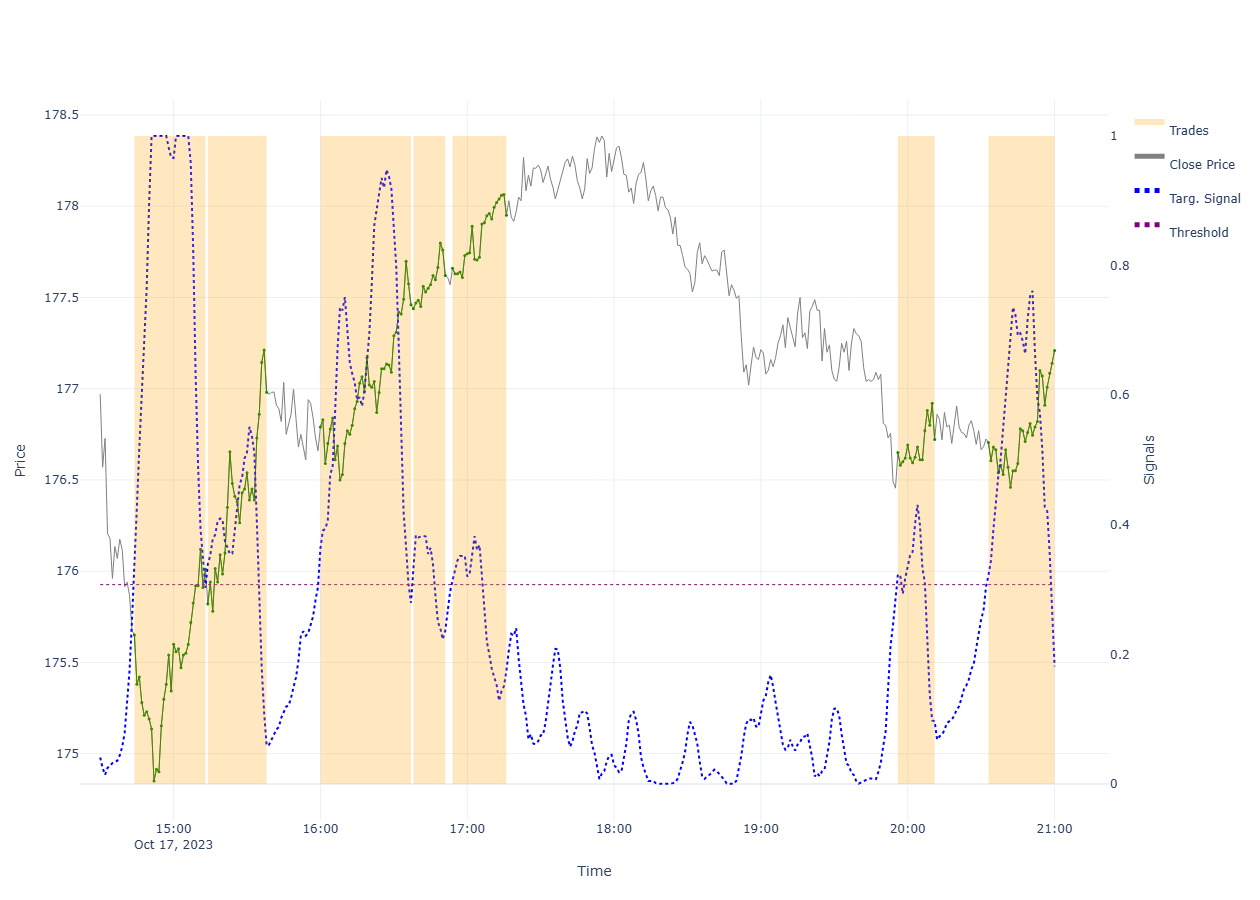

  Buy & Hold Return ($): -0.026
  Strategy Return ($): 1.382
  Trades Returns ($): [0.097, 0.896, 0.405, -0.085, 0.025, -0.193, 0.239]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-18


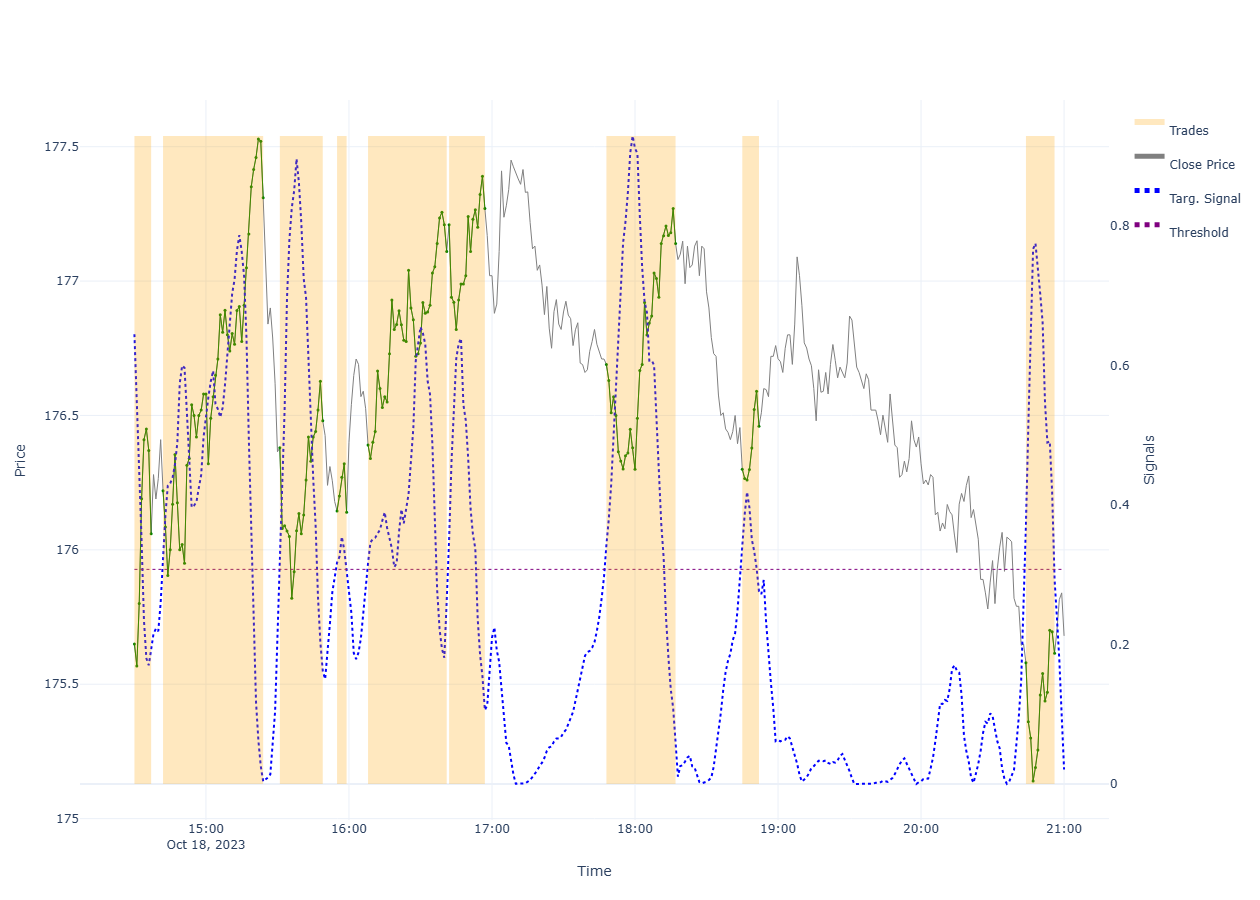

  Buy & Hold Return ($): -0.233
  Strategy Return ($): 0.638
  Trades Returns ($): [0.146, 0.825, -0.164, -0.27, 0.455, -0.206, 0.184, -0.104, -0.228]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-19


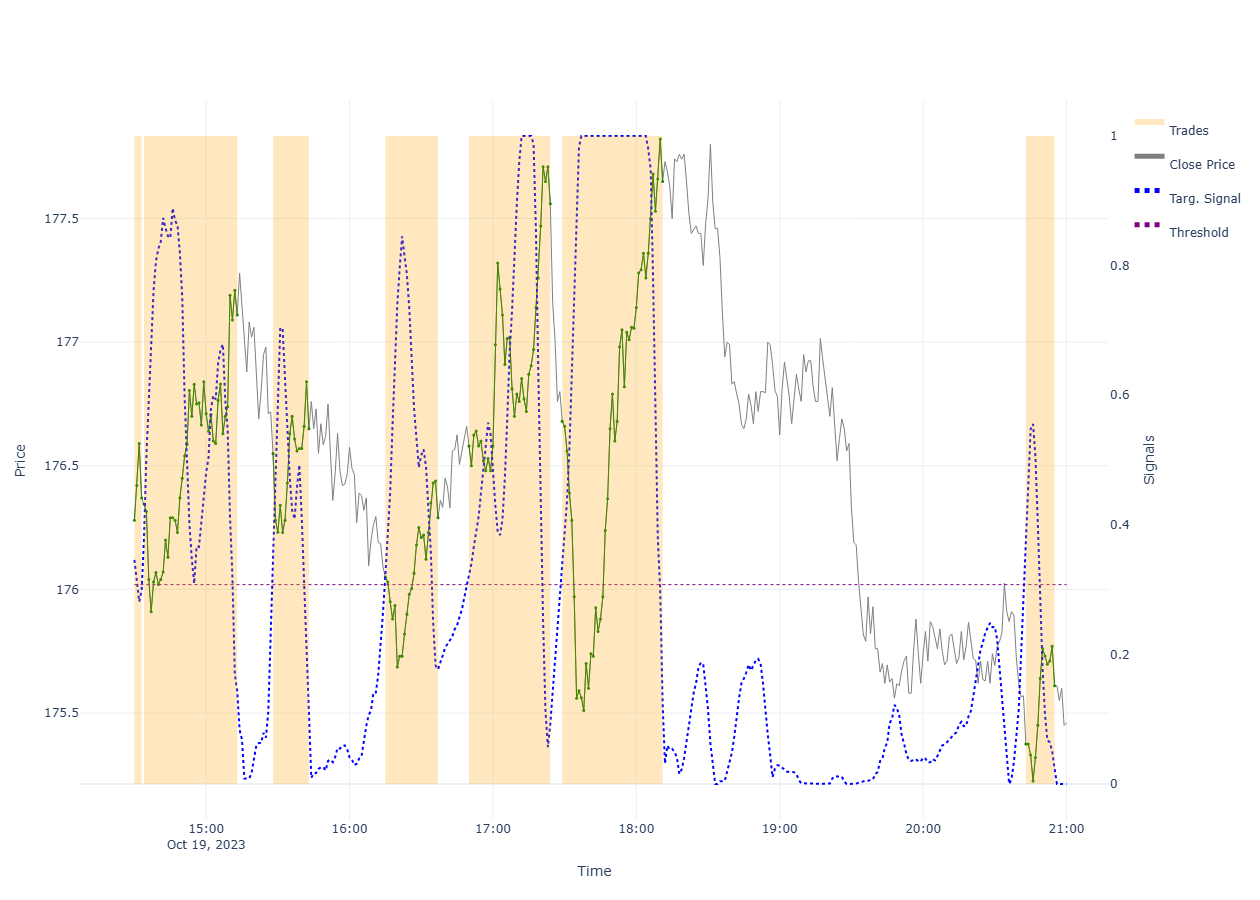

  Buy & Hold Return ($): -1.084
  Strategy Return ($): 1.527
  Trades Returns ($): [-0.175, 0.499, -0.164, -0.025, 0.714, 0.704, -0.028]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-20


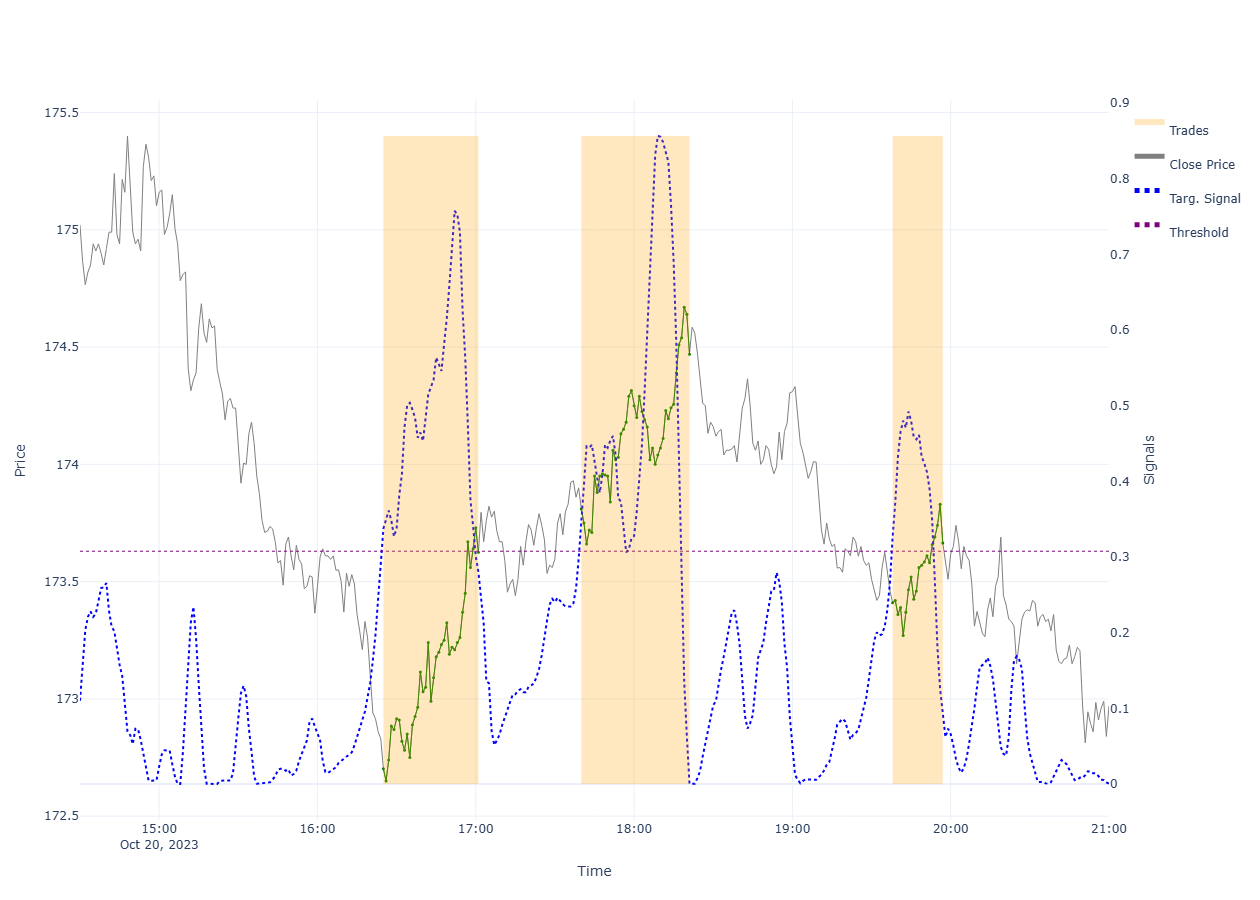

  Buy & Hold Return ($): -2.311
  Strategy Return ($): 1.057
  Trades Returns ($): [0.664, 0.398, -0.005]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-23


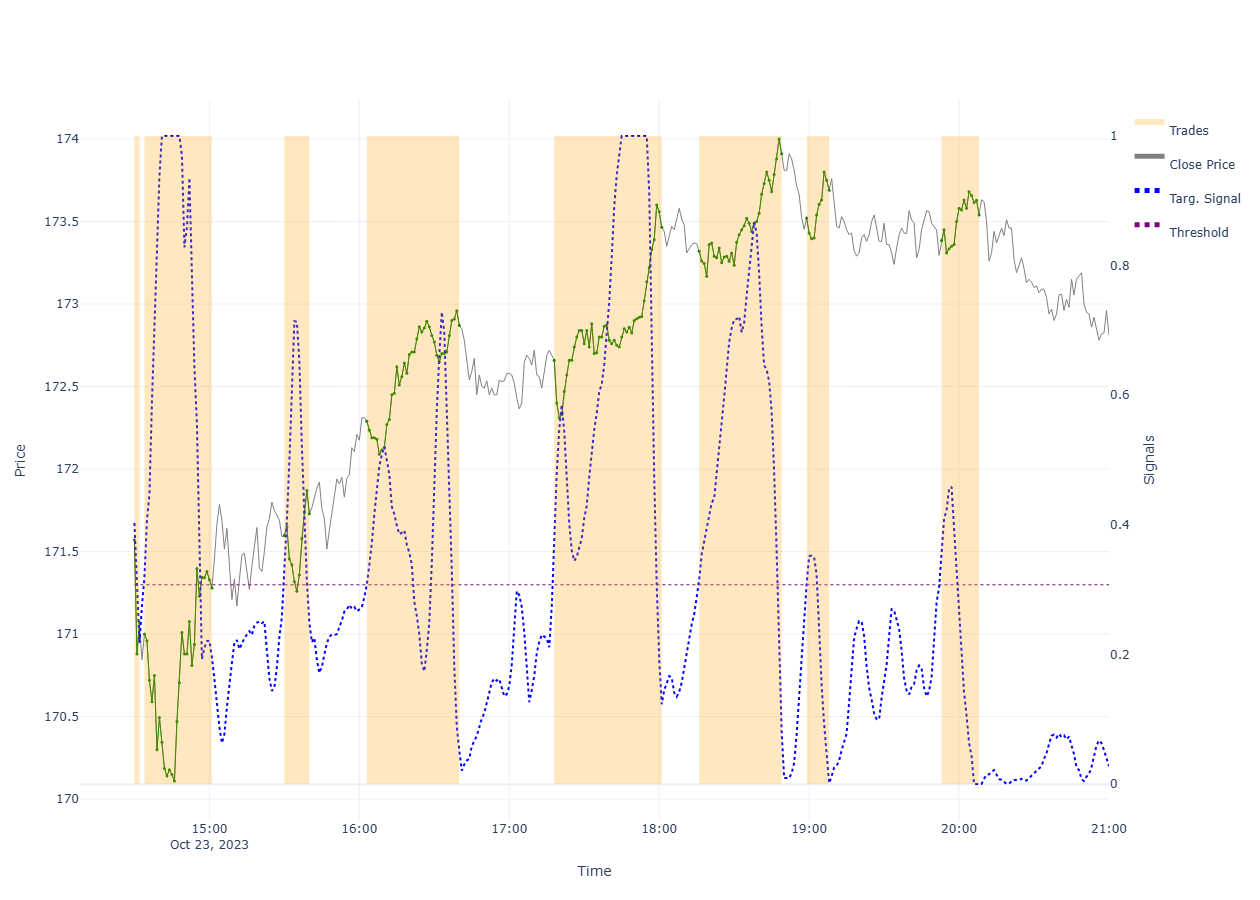

  Buy & Hold Return ($): 0.982
  Strategy Return ($): 0.141
  Trades Returns ($): [-0.757, 0.024, -0.125, 0.321, 0.546, 0.33, -0.092, -0.106]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-24


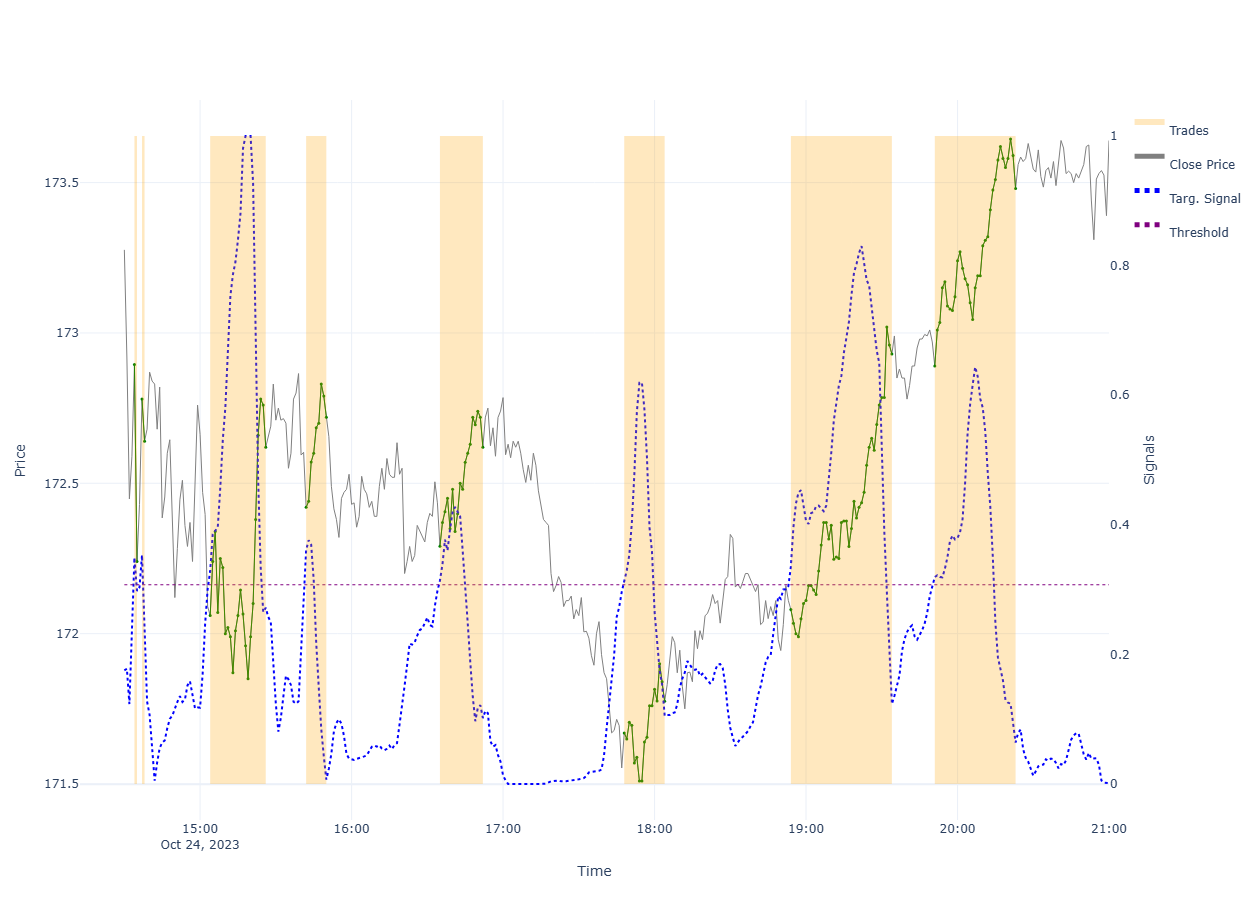

  Buy & Hold Return ($): 0.104
  Strategy Return ($): -0.13
  Trades Returns ($): [-0.914, -0.399, 0.301, 0.041, 0.071, -0.153, 0.591, 0.33]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-25


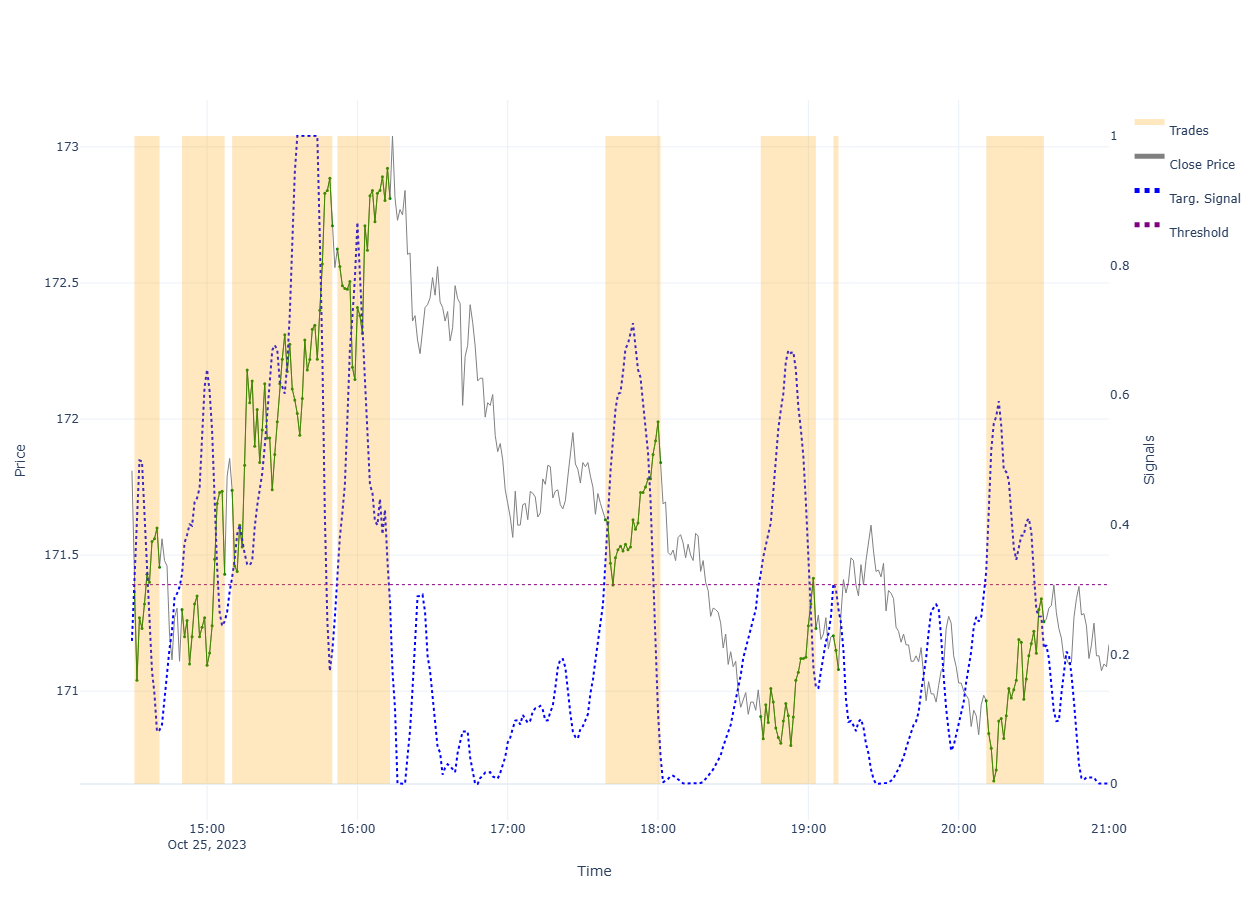

  Buy & Hold Return ($): -0.896
  Strategy Return ($): 0.018
  Trades Returns ($): [-0.166, -0.127, 0.713, -0.074, -0.048, 0.067, -0.38, 0.034]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-26


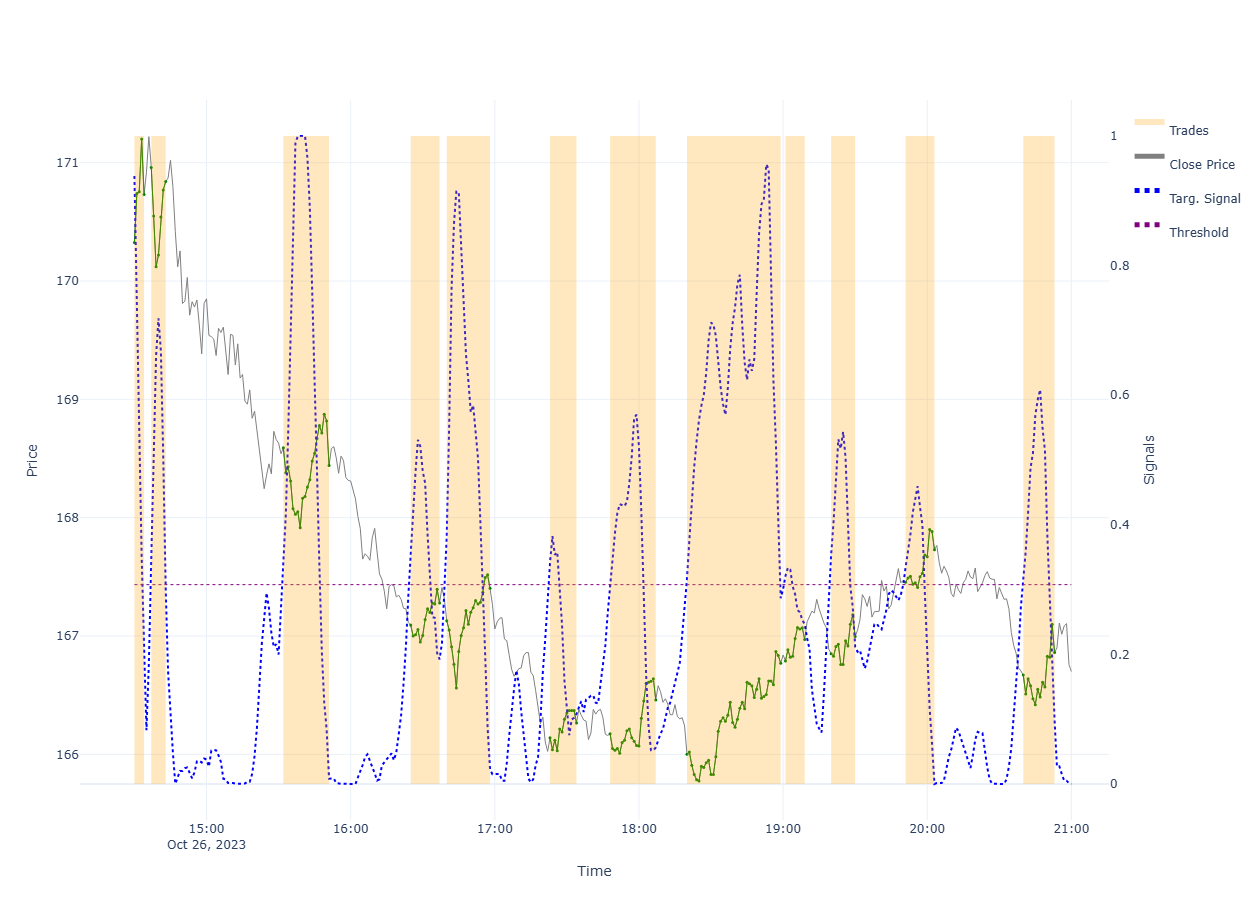

  Buy & Hold Return ($): -3.878
  Strategy Return ($): -0.451
  Trades Returns ($): [0.15, -0.376, -0.403, -0.065, 0.022, -0.125, 0.037, 0.52, -0.07, -0.105, 0.023, -0.06]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-27


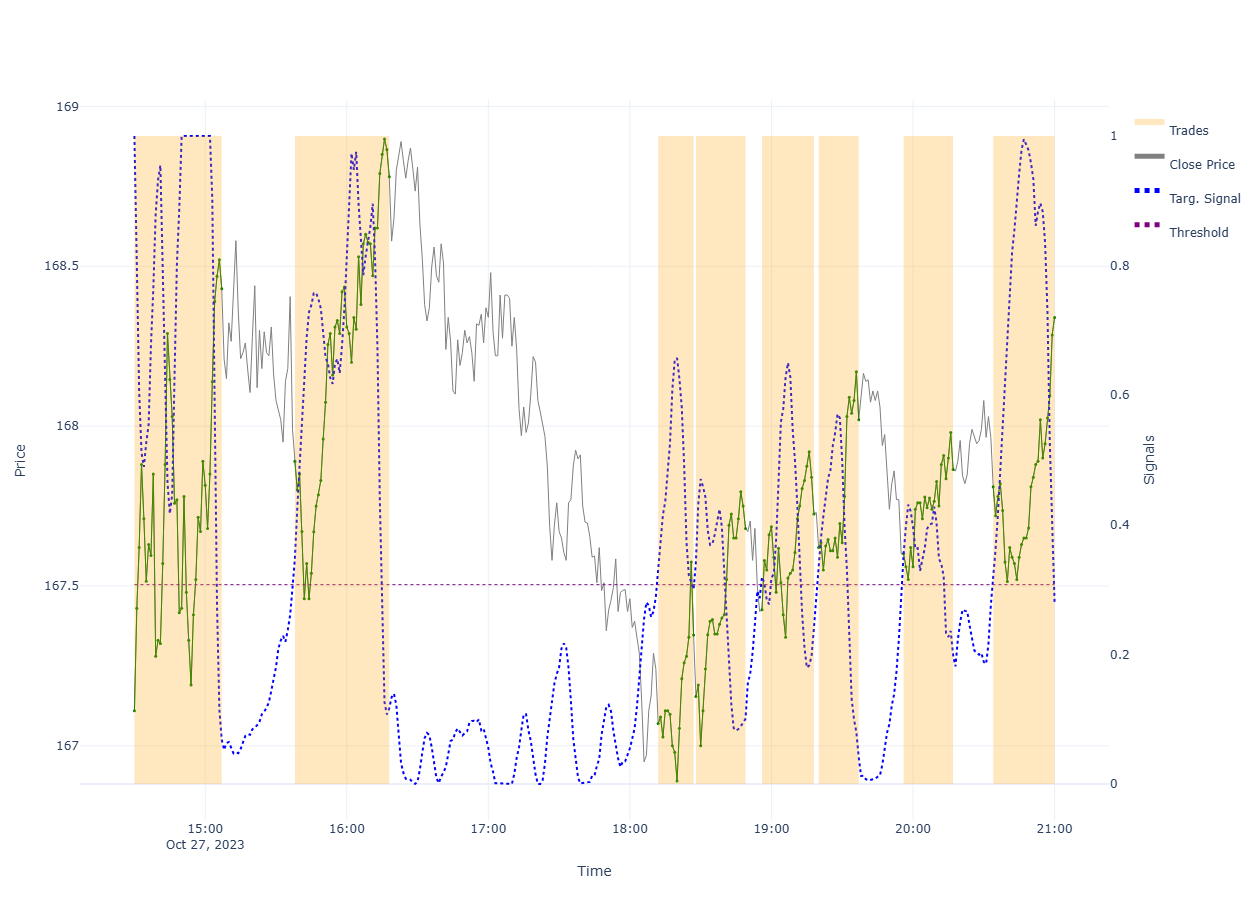

  Buy & Hold Return ($): 0.978
  Strategy Return ($): 2.492
  Trades Returns ($): [1.069, 0.637, 0.025, 0.274, 0.049, 0.148, 0.012, 0.277]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-30


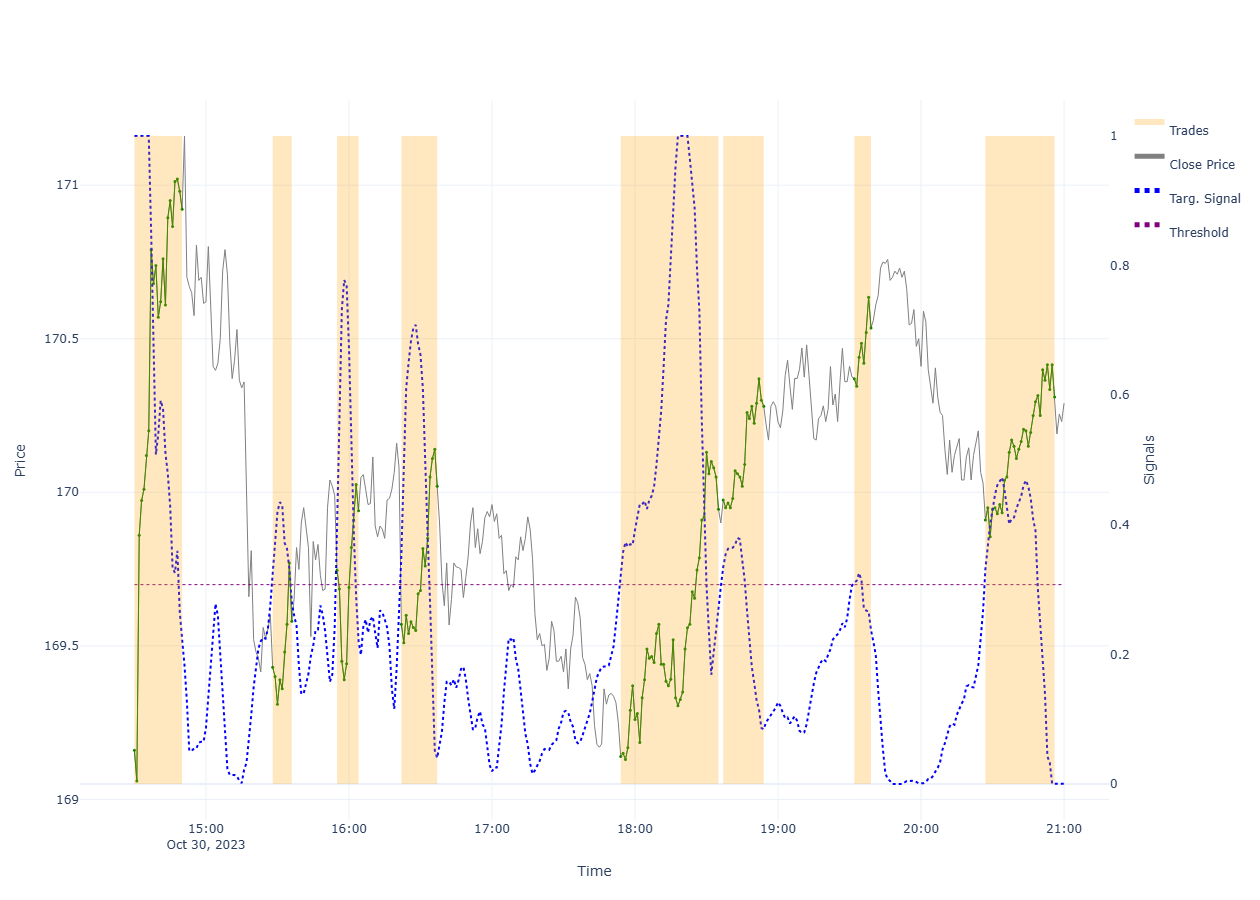

  Buy & Hold Return ($): 0.875
  Strategy Return ($): 2.191
  Trades Returns ($): [1.507, -0.105, -0.061, 0.195, 0.55, 0.049, -0.09, 0.145]
-------------------------------------------------------------------------------------------------------------------------------------------------

2023-10-31


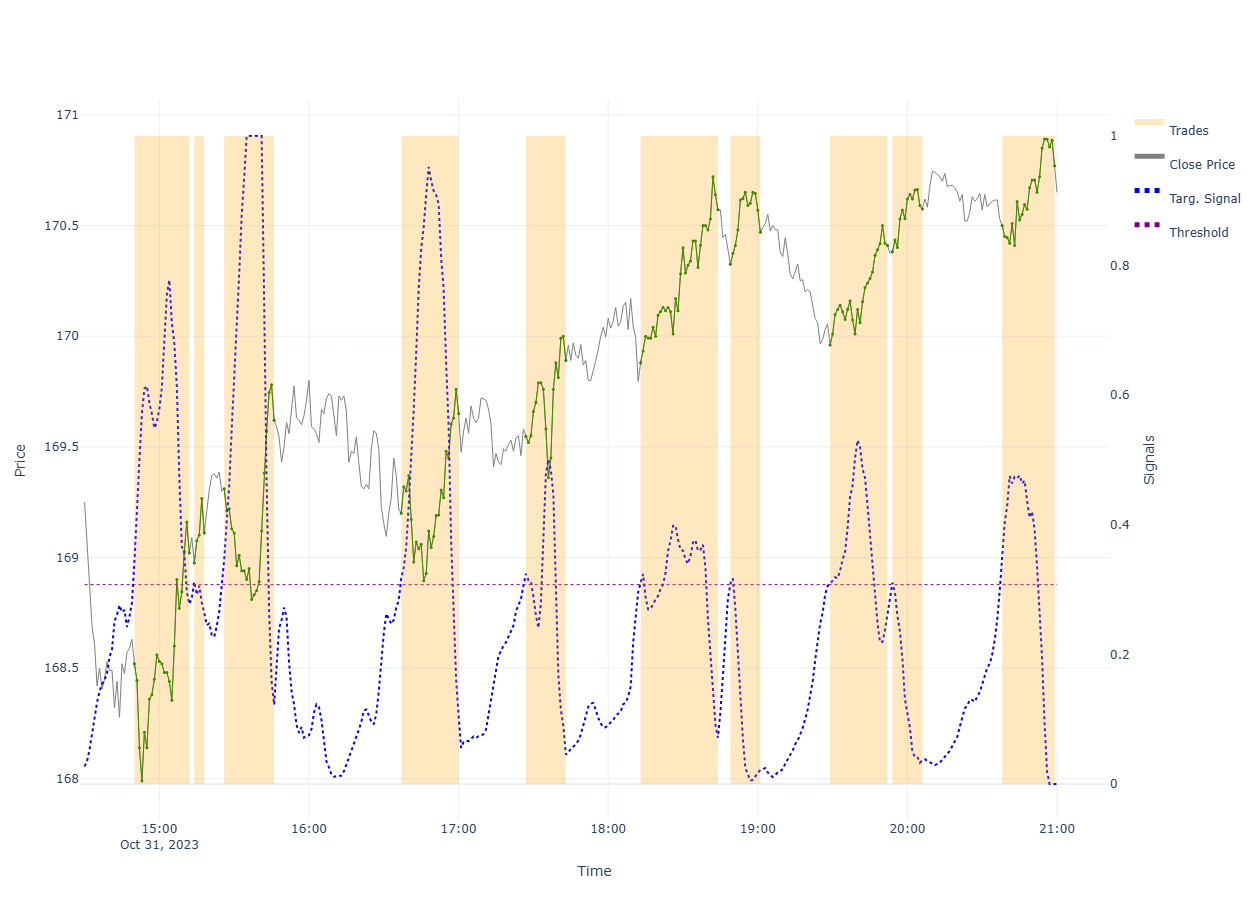

  Buy & Hold Return ($): 1.145
  Strategy Return ($): 0.941
  Trades Returns ($): [0.246, -0.118, 0.056, 0.196, 0.088, 0.435, -0.111, 0.194, -0.061, 0.014]
-------------------------------------------------------------------------------------------------------------------------------------------------

Overall Summary (2023-10-02 = 171.2383 → 2023-10-31 = 170.5220)

One-time buy&hold gain: -0.716
Buy & Hold – each day ($): 4.182
Strategy Return ($): 25.430
Trades Count: 170
Strategy return per trade: 0.150
Num. trading days: 22
Strategy return per trading day: 1.156


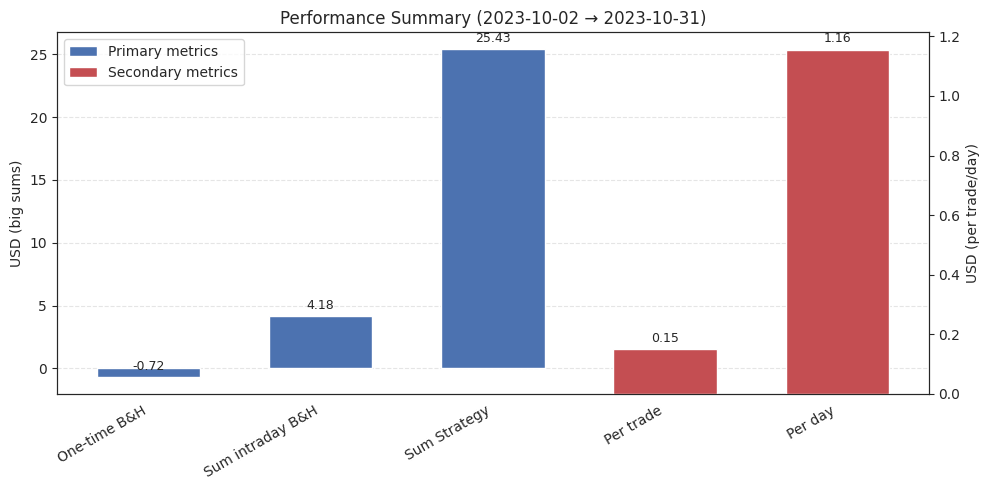


******************** Running pipeline on full dataset ********************
exec funct: 'identify_trades_by_day' (Detect and merge trades by day) ...
exec funct: 'compute_continuous_signal' (Compute raw signals and aggregate for scaling) ...
exec funct: 'generate_trade_actions' (Scale signals, generate actions, build final day-wise results) ...
exec funct: 'simulate_trading' (Run the simulation over all days) ...


Simulating trading days:  38%|███▊      | 2026/5400 [01:01<01:32, 36.54day/s]

In [ ]:
print('best_optuna_value:', params.best_optuna_value)
print('best_optuna_params:', params.best_optuna_params)

df_fin = saveDF_checkDAY(
                        df=df,
                        best_optuna_params=params.best_optuna_params
                        )

df_fin

In [ ]:
pd.set_option('display.max_rows', None)

# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
